# Importing the required libraries

In [16]:
from torch.utils.data import Dataset,DataLoader,random_split
from typing import Any,Tuple,Optional,Callable
import PIL
import csv
import pathlib
import torch

import torch.nn as nn
from torch.optim import Adam,lr_scheduler
from torchvision.transforms.v2 import ToTensor,Resize,Compose,ColorJitter,RandomRotation,AugMix,RandomCrop,GaussianBlur,RandomEqualize,RandomHorizontalFlip,RandomVerticalFlip
import matplotlib.pyplot as plt
import pickle

# selecting our gpu accelerator

In [17]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [18]:
device = torch.device('mps') if torch.backends.mps.is_available() else torch.device('cpu')
device

device(type='mps')

# Make a custom class for the gtsrb dataset

In [19]:
class GTSRB(Dataset):
    def __init__(self,
                 root: str,
                 split: str,
                 transform: Optional[Callable] = None):
       
        
        
        self.base_folder = pathlib.Path(root)
        self.csv_file = self.base_folder / ('Train.csv' if split =='train' else 'Test.csv')
        
        
        with open(''+str(self.csv_file)) as csvfile:
           samples = [(''+str(self.base_folder / row['Path']),int(row['ClassId'])) 
            for row in csv.DictReader(csvfile,delimiter=',',skipinitialspace=True)
                ]


        self.samples = samples
        self.split = split
        self.transform = transform

    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, index: int) -> Tuple:
        path,classId =  self.samples[index]
        sample = PIL.Image.open(path).convert('RGB')
        if self.transform is not None:
            sample = self.transform(sample)
        return sample,classId
     

# Augmenting our data by applying some transformations (brightness, contrast, vertical-horizontal flip, Rotations, Blur...)

In [21]:
train_transforms = Compose([
    # ColorJitter(brightness=1.0, contrast=0.5, saturation=1, hue=0.1),
    # RandomEqualize(0.4),
    # AugMix(),
    # RandomHorizontalFlip(0.3),
    # RandomVerticalFlip(0.3),
    # GaussianBlur((3,3)),
    # RandomRotation(30),

    Resize([32,32]),
    ToTensor(),
    
])
validation_transforms =  Compose([
    Resize([32,32]),
    ToTensor(),
    
])

# splitting our dataset into train and validation 

In [22]:
def train_test_split(dataset,train_size):

    train_size = int(train_size * len(dataset))
    test_size = int(len(dataset) - train_size)
    return random_split(dataset,[train_size,test_size])

In [23]:
dataset = GTSRB(root='GTSRB_dataset',split="train")
train_set,validation_set = train_test_split(dataset,train_size=0.8)
print(f'training size : {len(train_set)}, Validation size : {len(validation_set)}')

training size : 31367, Validation size : 7842


# visualizing the data

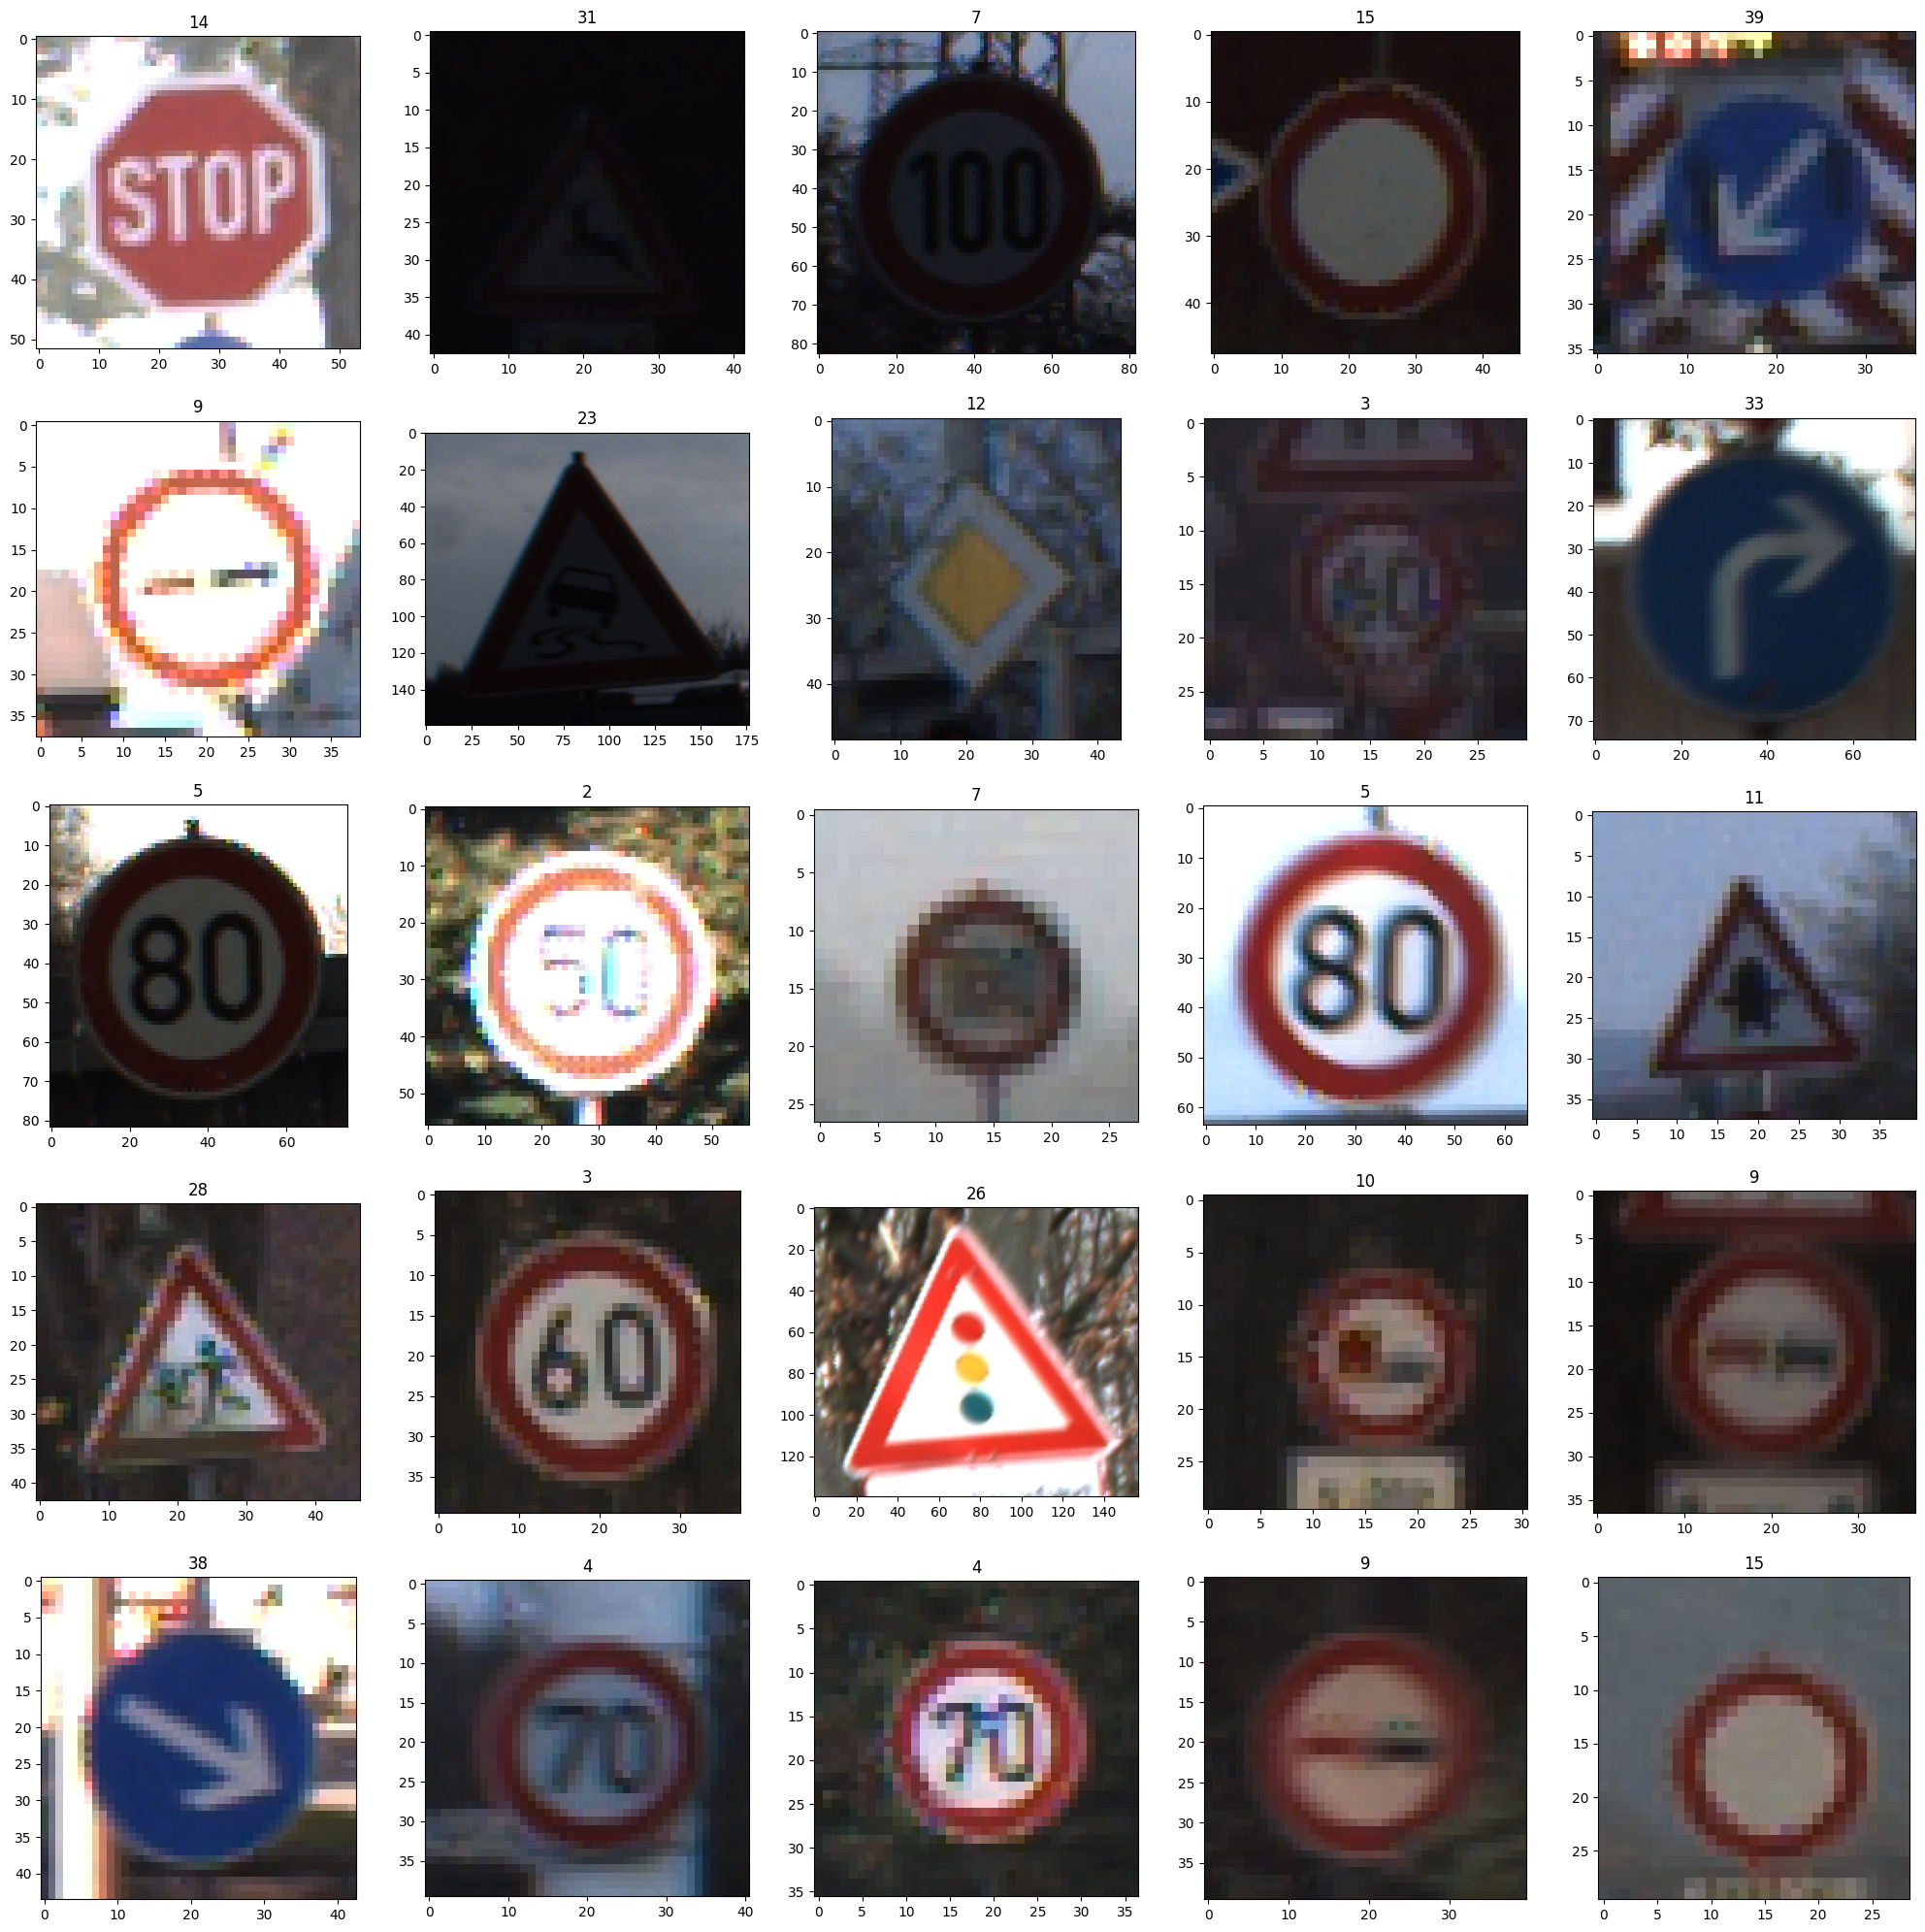

In [24]:
plt.figure(figsize=(25,25))
for i in range(1,26):
    input,label = train_set[i]
    plt.subplot(5,5,i)
    plt.title(label)
    plt.imshow(input)
    

# Applying the transformations

In [25]:
train_set.dataset.transform = train_transforms
validation_set.dataset.transform = validation_transforms

# Loading the data

In [26]:
BATCH_SIZE = 64
train_loader = DataLoader(dataset=train_set,batch_size=BATCH_SIZE,shuffle=True)
validation_loader = DataLoader(dataset=validation_set,batch_size=BATCH_SIZE)

# Building a convolutional neural network model

In [27]:
class NN(nn.Module):
    def __init__(self,input_dim,output_dim):
        super(NN,self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim

      
      
        self.metrics = {}
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        self.l1 = nn.Linear(self.input_dim,50)
        self.l2 = nn.Linear(50,20)
        self.l3 = nn.Linear(20,output_dim)
        
        
    def forward(self,input):
        
        flatten = self.flatten(input)
        dense_l1 = self.l1(flatten)
        act_l1 = self.relu(dense_l1)
        dense_l2 = self.l2(act_l1)
        act_l2 = self.relu(dense_l2)
        output = self.l3(act_l2)
        
        return output
    
    def training_metrics(self,positives,data_size,loss):
        acc = positives/data_size
        return loss,acc
    
    def validation_metrics(self,validation_data,loss_function):
       data_size = len(validation_data)
       correct_predictions = 0
       total_samples = 0
       val_loss = 0

       model = self.eval()
       with torch.no_grad() : 
        for step,(input,label) in enumerate(validation_data):
            input,label = input.to(device),label.to(device)
            prediction = model.forward(input)
            loss = loss_function(prediction,label)
            val_loss = loss.item()
            _,predicted = torch.max(prediction,1)
            correct_predictions += (predicted == label).sum().item()
            total_samples += label.size(0)

       val_acc = correct_predictions/total_samples

       return val_loss,val_acc

    def history(self):
        return self.metrics

            


    def compile(self,train_data,validation_data,epochs,loss_function,optimizer,learning_rate_scheduler):
        val_acc_list = []
        val_loss_list = []

        train_acc_list = []
        train_loss_list = []

        learning_rate_list = []

        print('training started ...')
        STEPS = len(train_data)
        for epoch in range(epochs):
            lr = optimizer.param_groups[0]["lr"]
            learning_rate_list.append(lr)
            correct_predictions = 0
            total_examples = 0
            loss = 0
            with tqdm.trange(STEPS) as progress:

                for step,(input,label) in enumerate(train_loader):

                    input,label = input.to(device),label.to(device)
                    prediction = self.forward(input)

                    _, predicted = torch.max(prediction, 1)
                    correct_predictions += (predicted == label).sum().item()
                    total_examples += label.size(0)
                    l = loss_function(prediction,label)
                    loss = l.item()
                    l.backward()
                    optimizer.step()
                    optimizer.zero_grad()

                    progress.colour = 'green'
                    progress.desc = f'Epoch [{epoch+1}/{EPOCHS}], Step [{step+1}/{STEPS}], Learning Rate [{lr}], Loss [{"{:.4f}".format(l)}], Accuracy [{"{:.4f}".format(correct_predictions/total_examples)}]'
                    progress.update(1)

            training_loss,training_acc = self.training_metrics(correct_predictions,total_examples,loss)
            train_acc_list.append(training_acc)
            train_loss_list.append(training_loss)

            val_loss, val_acc = self.validation_metrics(validation_data,loss_function)
            val_acc_list.append(val_acc)
            val_loss_list.append(val_loss)
            
            print(f'val_accuracy [{val_acc}], val_loss [{val_loss}]')

            
            learning_rate_scheduler.step()
        
        metrics_dict = {
                'train_acc':train_acc_list,
                'train_loss':train_loss_list,
                'val_acc':val_acc_list,
                'val_loss':val_loss_list,
                'learning_rate':optimizer.param_groups[0]["lr"]
            }
        self.metrics = metrics_dict
        print('training complete !')    

# Training our model

In [30]:
import tqdm
EPOCHS = 20
LEARNING_RATE = 0.0008
INPUT_DIM = 3*32*32
OUTPUT_DIM = 43
model = NN(INPUT_DIM,OUTPUT_DIM).to(device)

optimizer = Adam(params=model.parameters(),lr=LEARNING_RATE)
lr_s = lr_scheduler.LinearLR(optimizer,start_factor=1.0,end_factor=0.5,total_iters=10)
loss = nn.CrossEntropyLoss()


In [31]:
model.compile(train_data=train_loader,validation_data=validation_loader,epochs=EPOCHS,loss_function=loss,optimizer=optimizer,learning_rate_scheduler=lr_s)

training started ...


Epoch [1/20], Step [491/491], Learning Rate [0.0008], Loss [2.4239], Accuracy [0.2400]: 100%|██████████| 491/491 [00:17<00:00, 28.47it/s]


val_accuracy [0.41048201989288446], val_loss [2.052760124206543]


Epoch [2/20], Step [491/491], Learning Rate [0.00076], Loss [1.7978], Accuracy [0.4867]: 100%|██████████| 491/491 [00:17<00:00, 28.53it/s]


val_accuracy [0.5294567712318287], val_loss [1.6007906198501587]


Epoch [3/20], Step [491/491], Learning Rate [0.00072], Loss [1.1605], Accuracy [0.5853]: 100%|██████████| 491/491 [00:15<00:00, 30.92it/s]


val_accuracy [0.618592195868401], val_loss [1.16780686378479]


Epoch [4/20], Step [491/491], Learning Rate [0.00068], Loss [1.0002], Accuracy [0.6461]: 100%|██████████| 491/491 [00:15<00:00, 31.50it/s]


val_accuracy [0.6511094108645754], val_loss [1.1081641912460327]


Epoch [5/20], Step [491/491], Learning Rate [0.00064], Loss [1.4068], Accuracy [0.6919]: 100%|██████████| 491/491 [00:15<00:00, 31.36it/s]


val_accuracy [0.7086202499362407], val_loss [0.9213138818740845]


Epoch [6/20], Step [491/491], Learning Rate [0.0006000000000000001], Loss [0.8454], Accuracy [0.7278]: 100%|██████████| 491/491 [00:15<00:00, 30.92it/s]


val_accuracy [0.6725325172149962], val_loss [0.9928631782531738]


Epoch [7/20], Step [491/491], Learning Rate [0.0005600000000000001], Loss [0.8885], Accuracy [0.7560]: 100%|██████████| 491/491 [00:17<00:00, 28.71it/s]


val_accuracy [0.7556745728130579], val_loss [0.756065309047699]


Epoch [8/20], Step [491/491], Learning Rate [0.0005200000000000001], Loss [1.1613], Accuracy [0.7777]: 100%|██████████| 491/491 [00:15<00:00, 31.83it/s]


val_accuracy [0.7663861259882683], val_loss [0.7053403258323669]


Epoch [9/20], Step [491/491], Learning Rate [0.00048000000000000007], Loss [0.7605], Accuracy [0.7930]: 100%|██████████| 491/491 [00:11<00:00, 43.88it/s]


val_accuracy [0.7938026013771997], val_loss [0.5922813415527344]


Epoch [10/20], Step [491/491], Learning Rate [0.00044000000000000007], Loss [0.5183], Accuracy [0.8046]: 100%|██████████| 491/491 [00:11<00:00, 42.45it/s]


val_accuracy [0.7821984187707217], val_loss [0.5594005584716797]


Epoch [11/20], Step [491/491], Learning Rate [0.0004000000000000001], Loss [0.7050], Accuracy [0.8188]: 100%|██████████| 491/491 [00:10<00:00, 44.65it/s]


val_accuracy [0.8142055598061719], val_loss [0.5230485200881958]


Epoch [12/20], Step [491/491], Learning Rate [0.0004000000000000001], Loss [0.9358], Accuracy [0.8223]: 100%|██████████| 491/491 [00:10<00:00, 44.74it/s]


val_accuracy [0.8293802601377199], val_loss [0.4718051254749298]


Epoch [13/20], Step [491/491], Learning Rate [0.0004000000000000001], Loss [0.8087], Accuracy [0.8317]: 100%|██████████| 491/491 [00:11<00:00, 41.19it/s]


val_accuracy [0.8325682223922469], val_loss [0.43806347250938416]


Epoch [14/20], Step [491/491], Learning Rate [0.0004000000000000001], Loss [0.2111], Accuracy [0.8361]: 100%|██████████| 491/491 [00:11<00:00, 40.99it/s]


val_accuracy [0.826064779393012], val_loss [0.4038546085357666]


Epoch [15/20], Step [491/491], Learning Rate [0.0004000000000000001], Loss [1.3266], Accuracy [0.8452]: 100%|██████████| 491/491 [00:13<00:00, 35.47it/s]


val_accuracy [0.8427697016067329], val_loss [0.42119622230529785]


Epoch [16/20], Step [491/491], Learning Rate [0.0004000000000000001], Loss [0.3721], Accuracy [0.8478]: 100%|██████████| 491/491 [00:16<00:00, 30.65it/s]


val_accuracy [0.8471053302728896], val_loss [0.3812125027179718]


Epoch [17/20], Step [491/491], Learning Rate [0.0004000000000000001], Loss [0.2871], Accuracy [0.8527]: 100%|██████████| 491/491 [00:14<00:00, 32.98it/s]


val_accuracy [0.8441724049987248], val_loss [0.3631441593170166]


Epoch [18/20], Step [491/491], Learning Rate [0.0004000000000000001], Loss [0.3553], Accuracy [0.8546]: 100%|██████████| 491/491 [00:14<00:00, 34.46it/s]


val_accuracy [0.8524611068604948], val_loss [0.3130097985267639]


Epoch [19/20], Step [491/491], Learning Rate [0.0004000000000000001], Loss [0.4767], Accuracy [0.8583]: 100%|██████████| 491/491 [00:13<00:00, 35.51it/s]


val_accuracy [0.8527161438408569], val_loss [0.33249568939208984]


Epoch [20/20], Step [491/491], Learning Rate [0.0004000000000000001], Loss [0.5967], Accuracy [0.8656]: 100%|██████████| 491/491 [00:13<00:00, 35.34it/s]


val_accuracy [0.8556490691150217], val_loss [0.2930271625518799]
training complete !


In [40]:
list(model.children())

[Flatten(start_dim=1, end_dim=-1),
 ReLU(),
 Linear(in_features=3072, out_features=50, bias=True),
 Linear(in_features=50, out_features=20, bias=True),
 Linear(in_features=20, out_features=43, bias=True)]

In [39]:
list(model.children())[2].weight

Parameter containing:
tensor([[-0.0018, -0.0029, -0.0123,  ..., -0.0096, -0.0148, -0.0185],
        [ 0.0081,  0.0133,  0.0088,  ...,  0.0135, -0.0107,  0.0116],
        [ 0.0037, -0.0129, -0.0159,  ..., -0.0061,  0.0006,  0.0065],
        ...,
        [ 0.0155,  0.0057, -0.0191,  ..., -0.0133, -0.0079,  0.0070],
        [ 0.0110, -0.0209, -0.0114,  ..., -0.0187, -0.0227, -0.0081],
        [-0.0172, -0.0018,  0.0090,  ..., -0.0075,  0.0018, -0.0087]],
       device='mps:0', requires_grad=True)

In [14]:
transforms = Compose([
    Resize([50,50]),
    ToTensor(),
    
])

testdata = GTSRB(root='GTSRB_dataset',split='test',transform=transforms)
print('testing size :',len(testdata))
test_dataloader = DataLoader(testdata)




testing size : 12630


In [15]:
from sklearn.metrics import accuracy_score

y_pred = []
y_true = []
model = model.eval().to(device)
with tqdm.tqdm(colour='red',total=len(test_dataloader)) as progress:
  
  with torch.no_grad() : 
    for id,(input,label) in enumerate(iter(test_dataloader)):
        input,label = input.to(device),label.to(device)
        y_true.append(label.item())
        prediction = model.forward(input)
        _,prediction = torch.max(prediction,1)
        y_pred.append(prediction.item())
        
        progress.desc = f'Test Accuracy : {accuracy_score(y_true,y_pred)} '
        progress.update(1)
        
       

Test Accuracy : 0.8058590657165479 : 100%|██████████| 12630/12630 [00:41<00:00, 302.30it/s]
